# Application of Random Matrix Theory to Drug Discovery

### Laksh Aithani, University of Cambridge

In [259]:
# Imports
import os

# RDkit, a chemoinformatics library
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [425]:
import functools

In [342]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [260]:
from sklearn.pipeline import Pipeline

In [261]:
from sklearn.decomposition import PCA

In [262]:
import warnings
warnings.filterwarnings('ignore')

In [263]:
# Dataset loading functions for ChemBL datasets
def load_dataset(file_name, drop_non_binders = True):
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Converting strings to floats, also set all non-numbers to NaN
    df['Standard Vaue'] = pd.to_numeric(df['Standard Value'],errors = 'coerce')

    # Drop Nans in affinity column
    df.dropna(subset = ['Standard Value'], inplace = True)
    df.reset_index(inplace = True)
    df = df.drop('index',axis = 1)
    
    # Filtering for only activities recorded in nanomolar affinity
    df = df[df['Standard Units'] == 'nM']    

    # Dropping any molecules that don't have a SMILES
    df = df.dropna(subset = ['Canonical Smiles'])
    
    # Considering only the binders (compounds with affinities of less than 1000nM)
    if drop_non_binders:
        df = df[df['Standard Value'] < 1000]
    
    # Dropping duplicate molecules
    df = df.drop_duplicates(subset = 'Canonical Smiles', keep = 'first')
    
    return df

In [264]:
df_train_test = load_dataset(os.path.join(os.getcwd(),'adr1b_chembl.csv'), drop_non_binders = True)
df_decoy = load_dataset(os.path.join(os.getcwd(), '5ht1a_chembl.csv'), drop_non_binders = False)

In [265]:
df_train_test.head()

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Unnamed: 43,Standard Vaue
3,CHEMBL251347,Ki,=,730.00,nM,6.14,NaN,16b,CHEMBL888304,Displacement of [125I]iodocyanopindolol from h...,...,NaN,COc1ccc(cc1)[C@H](CCc2ccccc2)NC[C@H](O)Cc3ccc(...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,FALSE,NaN,730.00
5,CHEMBL430390,EC50,=,19.95,nM,7.70,NaN,39,CHEMBL887286,Agonist activity at human beta-1 adrenergic re...,...,NaN,C[C@H](CNc1ccc(cc1)c2nc(cs2)C(=O)O)NC[C@H](O)c...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,FALSE,NaN,19.95
9,CHEMBL26917,IC50,=,186.00,nM,6.73,NaN,13,CHEMBL650687,Compound was tested for inhibition of [3H]dihy...,...,NaN,CC(C)NCC(O)COc1ccc(C)c2CCCc12,NaN,J. Med. Chem.,1982.0,1,UO_0000065,FALSE,NaN,186.00
11,CHEMBL39596,Ki,=,310.00,nM,6.51,NaN,5,CHEMBL651835,Ability to bind to human Beta-1 adrenergic rec...,...,NaN,C[C@H](Cc1ccc(OCC(=O)NO)cc1)NC[C@H](O)c2cccc(C...,NaN,Bioorg. Med. Chem. Lett.,1997.0,1,UO_0000065,FALSE,NaN,310.00
14,CHEMBL52407,IC50,=,580.00,nM,6.24,NaN,7c,CHEMBL883288,In vitro binding affinity towards cloned human...,...,NaN,CCCCCCCCc1onc(n1)N2CCc3cc(ccc23)S(=O)(=O)Nc4cc...,NaN,Bioorg. Med. Chem. Lett.,1999.0,1,UO_0000065,FALSE,NaN,580.00


In [266]:
df_decoy.head()

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Value,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Standard Vaue
0,CHEMBL27393,Ki,=,11.000,nM,7.96,NaN,23,CHEMBL616058,Binding affinity towards 5-hydroxytryptamine 1...,...,NaN,NaN,O=C(NCCCCN1CCN(CC1)c2ccccc2)c3ccccc3,NaN,J. Med. Chem.,1988.0,1,UO_0000065,True,11.000
1,CHEMBL352029,IC50,=,10.200,nM,7.99,NaN,2,CHEMBL615830,Binding affinity to 5-hydroxytryptamine 1A rec...,...,NaN,NaN,CC1=COc2ccccc2C(=O)N1CCCCN3CCN(CC3)c4ncccn4,NaN,Bioorg. Med. Chem. Lett.,2001.0,1,UO_0000065,False,10.200
2,CHEMBL92630,Ki,=,1600.000,nM,5.80,NaN,5,CHEMBL616310,Tested for affinity against 5-hydroxytryptamin...,...,NaN,NaN,CCCN1CCC[C@H](C1)c2cccc(OS(=O)(=O)c3ccc(C)cc3)c2,NaN,J. Med. Chem.,1994.0,1,UO_0000065,False,1600.000
3,CHEMBL43513,IC50,=,420.000,nM,6.38,NaN,19,CHEMBL615901,Inhibition of [3H]8-OH-DPAT binding at seroton...,...,NaN,NaN,O=C1N(CC#CCN2CCN(CC2)c3nsc4ccccc34)C(=O)c5ccccc15,NaN,J. Med. Chem.,1996.0,1,UO_0000065,False,420.000
4,CHEMBL132657,Ki,=,3.715,nM,8.43,NaN,26,CHEMBL616349,Binding affinity at 5-hydroxytryptamine 1A rec...,...,NaN,NaN,Clc1cccc2C(CCCN3CCN(CC3)c4cccc5OCCOc45)Cc12,NaN,J. Med. Chem.,1995.0,1,UO_0000065,False,3.715


In [267]:
def generate_morgan_matrix(smiles):
    
    # Function that generates the Morgan matrix - can take a couple of minutes
    # for 1000s of molecules
    
    # Input is a pandas Series of SMILES representation of molecules
    
    morgan_matrix = np.zeros((1,2048))
    l = len(smiles)
    
    # Iterate through the compounds
    for i in range(l):
        
        # For each compound, get the structure, convert to Morgan fingerprint,
        # and add to the data matrix
        
        try:
            compound = Chem.MolFromSmiles(smiles[i])
            fp = Chem.AllChem.GetMorganFingerprintAsBitVect(compound, 2, nBits = 2048)
            fp = fp.ToBitString()
            matrix_row = np.array([int(x) for x in list(fp)])
            morgan_matrix = np.row_stack((morgan_matrix, matrix_row))
            
            # Progress checker
            if i%500==0:
                percentage = np.round(100*(i/l),1)
                print(f'{percentage}% done')
        except:
            print(f'problem index:{i}')
    
    # Deleting first row of zeros
    morgan_matrix = np.delete(morgan_matrix, 0, axis = 0)
    
    print('\n')
    print(f'Morgan Matrix dimensions:{morgan_matrix.shape}')
    return morgan_matrix

In [268]:
smiles_train_test = df_train_test['Canonical Smiles']
smiles_train_test = smiles_train_test.reset_index()['Canonical Smiles']
affinity_train_test = df_train_test['Standard Value']

# Making 
binding_threshold = 1000  # units of nM
affinity_train_test = affinity_train_test.apply(lambda x: 1 if x<1000 else 0)

smiles_decoy = df_decoy['Canonical Smiles']
smiles_decoy = smiles_decoy.reset_index()['Canonical Smiles']
affinity_decoy = pd.Series([0 for i in range(len(smiles_decoy))])

In [269]:
Morgan_matrix_train_test = generate_morgan_matrix(smiles_train_test)

0.0% done
56.1% done


Morgan Matrix dimensions:(892, 2048)


In [270]:
Morgan_matrix_decoy = generate_morgan_matrix(smiles_decoy)

0.0% done
12.3% done
24.6% done
36.8% done
49.1% done
61.4% done
73.7% done
86.0% done
98.2% done


Morgan Matrix dimensions:(4072, 2048)


In [278]:
big_matrix = np.concatenate((Morgan_matrix_train_test, Morgan_matrix_decoy),axis = 0); big_matrix.shape

(4964, 2048)

In [281]:
indicators = np.concatenate((affinity_train_test, affinity_decoy)); indicators.shape

(4964,)

In [282]:
X_train, X_test, y_train, y_test = train_test_split(big_matrix, indicators, stratify = indicators, random_state = 3)

In [30]:
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [198]:
Morgan_matrix_train_test.shape

(1617, 2048)

In [ ]:
steps = [('scaler',StandardScaler())]

In [ ]:
pipeline = Pipeline(steps)

In [492]:
class RMTClassifier(object):
    
    def __init__(self,threshold_multiple = 1, cutoff = 0.95):
        self.cutoff = cutoff
        self.thresh_multiple = threshold_multiple
        

    def _RMT(self, matrix):
        N, p = matrix.shape
        
        gamma = p/N
        thresh = ((1 + np.sqrt(gamma))**2)*self.thresh_multiple
        
        scaler = StandardScaler()
        matrix = scaler.fit_transform(matrix)
        pca = PCA()
        pca.fit_transform(matrix)
        
        # Find significant vector space V
        dim_V = pca.explained_variance_[pca.explained_variance_>thresh].shape[0]
        
        return scaler, pca, dim_V
    
    def _distance_to_projection(self, data, vector_space):
        # Given a vector space, V, we project the data onto that vector space, and then return distance to
        # the original data
        
        # V is formatted such that different vectors are along different columns
        
        # Data matrix is formatted such that rows correspond to different data points
        # and columns correspond to different features
        
        # projected_matrix = D V V.T
        #
        # finally, subtract original data (projectect_matrix - D) take euclidean norm along columns 
        
        # Also note that the vector space can be as large/small as required
        
        return np.linalg.norm( np.dot(data, 
                                      np.dot( vector_space, vector_space.T ) )  - data,
                             axis = 1)
    
    
    def fit(self, X,y):
        
        # This code is optimized for speed using numpy matrix operations
        X,y = np.array(X), np.array(y)
        actives = X[np.where(y==1)[0],:]
        inactives = X[np.where(y==0)[0],:]
        
        self.scaler_actives, self.pca_actives, self.dim_V_actives = self._RMT(actives)
        self.scaler_inactives, self.pca_inactives, self.dim_V_inactives = self._RMT(inactives)
        
        metric = self.predict_scores(actives)
        
        idx = np.argsort(metric) #sorts in ascending order
        metric = metric[idx]
        cutoff_idx = int(self.cutoff * len(metric))
        self.epsilon = metric[cutoff_idx]

    
    def predict_scores(self, X_test):
        # As described in https://www.pnas.org/content/116/9/3373
        self.scores = (self._distance_to_projection(self.scaler_actives.transform(X_test), 
                                                 self.pca_actives.components_.T[:, :self.dim_V_actives])
                  - 
                  
                 self._distance_to_projection(self.scaler_inactives.transform(X_test), 
                                                 self.pca_inactives.components_.T[:, :self.dim_V_inactives]))
        return self.scores
    
    
    
    def predict(self, X_test, epsilon_multiple = 1):
        
        scores = self.predict_scores(X_test)
        predictions = np.array([1 if x<self.epsilon * epsilon_multiple else 0 for x in scores])
        
        return predictions
    
    def return_indices_of_common_molecules_of_active_eig(self, matrix, n=5,eigenvector_index=0):
        
        # returns molecules that lie closest to the selected eigenvector
        # default number of molecules returned = 5
        
        # Pick out the (best) eigenvector
        eig = self.feature_vecs[:,eigenvector_index].reshape(self.p,1)
        
        # Project molecules onto the one-dimensional vector space and get the indices of the top 5 molecules
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        return np.argpartition(    np.dot(matrix, eig).reshape(matrix.shape[0])   , -n)[-n:]
        
        

In [493]:
# Fit the model
clf = RMTClassifier()
clf.fit(X_train,y_train)

In [494]:
# Predict true positive rate
test_preds = clf.predict(X_test, epsilon_multiple=1)

In [495]:
print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

confusion_matrix 
 [[997  21]
 [ 19 204]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1018
           1       0.91      0.91      0.91       223

    accuracy                           0.97      1241
   macro avg       0.94      0.95      0.95      1241
weighted avg       0.97      0.97      0.97      1241



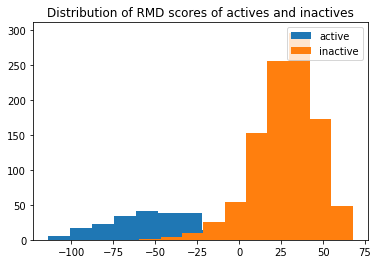

In [523]:
plt.hist(clf.predict_scores(X_test[np.argwhere(y_test==1).reshape(np.argwhere(y_test==1).shape[0]),:]),label='active')
plt.hist(clf.predict_scores(X_test[np.argwhere(y_test==0).reshape(np.argwhere(y_test==0).shape[0]),:]),label='inactive')
plt.legend(loc = 'upper right')
plt.title('Distribution of RMD scores of actives and inactives')
plt.show()

In [418]:
# Code to get pharmacophore of an eigenvector

from rdkit.Chem import rdFMCS

# Specify which eigenvector/pharmacophore you want to find (eigenvector_index)
# Specify the number of molecules to search substructure (n)
idxs = clf.return_indices_of_common_molecules_of_eig(X_train,n=3,eigenvector_index=0)
print(idxs)

df_idxs = y_train.iloc[idxs,:]['index']
smiles_strings = df_train_test.loc[df_idxs]['Canonical Smiles']
mls = [Chem.MolFromSmiles(x) for x in list(smiles_strings)]
res = rdFMCS.FindMCS(mls)
patt = Chem.MolFromSmarts(res.smartsString);patt

AttributeError: 'RMTClassifier' object has no attribute 'return_indices_of_common_molecules_of_eig'

In [432]:
clf = RMTClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
print('accuracy:',np.array([1 if i==j else 0 for i,j in zip(y_test, test_preds)]).mean())

accuracy: 0.967767929089444


In [444]:
def false_positive_true_positive(clf,multiple):
    # Must be a fitted classifier
    test_preds = clf.predict(X_test,epsilon_multiple = multiple)
    #decoy_preds = clf.predict(Morgan_matrix_decoy, epsilon_multiple = multiple)
    
    
    tp = np.dot(y_test, test_preds)/np.sum(y_test)
    fp = np.sum([1 if i!=j and i==0 else 0 for i,j in zip(y_test, test_preds)])/(len(y_test)-np.sum(y_test))
    return fp, tp

In [445]:
false_positive_true_positive(clf,1)

(0.0206286836935167, 0.9147982062780269)

In [455]:
# Plot ROC Curve
x,y = [],[]
for idx,val in enumerate(np.linspace(-5,5,100)):
    
    # Progress checker
    if idx%8==0:
        print(f'progress:{(idx+1)*2}%')
    fp, tp = false_positive_true_positive(clf,val)
    x.append(fp)
    y.append(tp)

progress:2%
progress:18%
progress:34%
progress:50%
progress:66%
progress:82%
progress:98%
progress:114%
progress:130%
progress:146%
progress:162%
progress:178%
progress:194%


In [456]:
AUC = sklearn.metrics.auc(x, y)
AUC = round(AUC,2); AUC

0.99

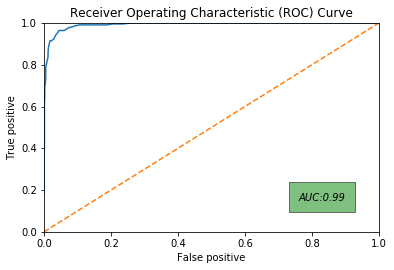

In [457]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False positive')
ax.set_ylabel('True positive')
ax.text(0.76,0.15, f'AUC:{str(AUC)}', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
ax.plot(x, y)
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--')
ax.axis([0, 1, 0, 1])
plt.show()
fig.savefig("ROC_Curve.png",dpi = 1000)